In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

%matplotlib inline

In [2]:
import plot
import calculate

In [3]:
CAREER_LENGTH = 5 #this defines the criterion which we use to filter authors

MAX_CAREER_LENGTH_COHORT = 15    # this defines how long we follow each cohort


In [4]:
# Publication data
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head())


authorPublicationData no duplicates:  9471668


In [5]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-'+ str(CAREER_LENGTH) + '-year_extended.csv', encoding='utf-8')

In [6]:
credible_authors = credible_authors.set_index('start_year')

print("credible_authors: ", credible_authors.shape[0])
print(credible_authors.head())

#print(credible_authors[credible_authors['author'] == 'donatella sciuto'])
credible_authors.rename(columns={'num_pub':'total_num_pub'}, inplace=True)



credible_authors:  503859
                      author  end_year  num_pub  career_length  \
start_year                                                       
2001        'maseka lesaoana      2015        2             15   
2005           sheldon dealy      2009        2              5   
1985         sheldon epstein      1996        4             12   
2010           sheldon green      2014        3              5   
2002        sheldon j. mckay      2016        7             15   

            early_career_prod  early_career_prod_1  early_career_prod_2  \
start_year                                                                
2001                        1                    1                    1   
2005                        1                    1                    1   
1985                        1                    1                    1   
2010                        1                    1                    1   
2002                        1                    1           

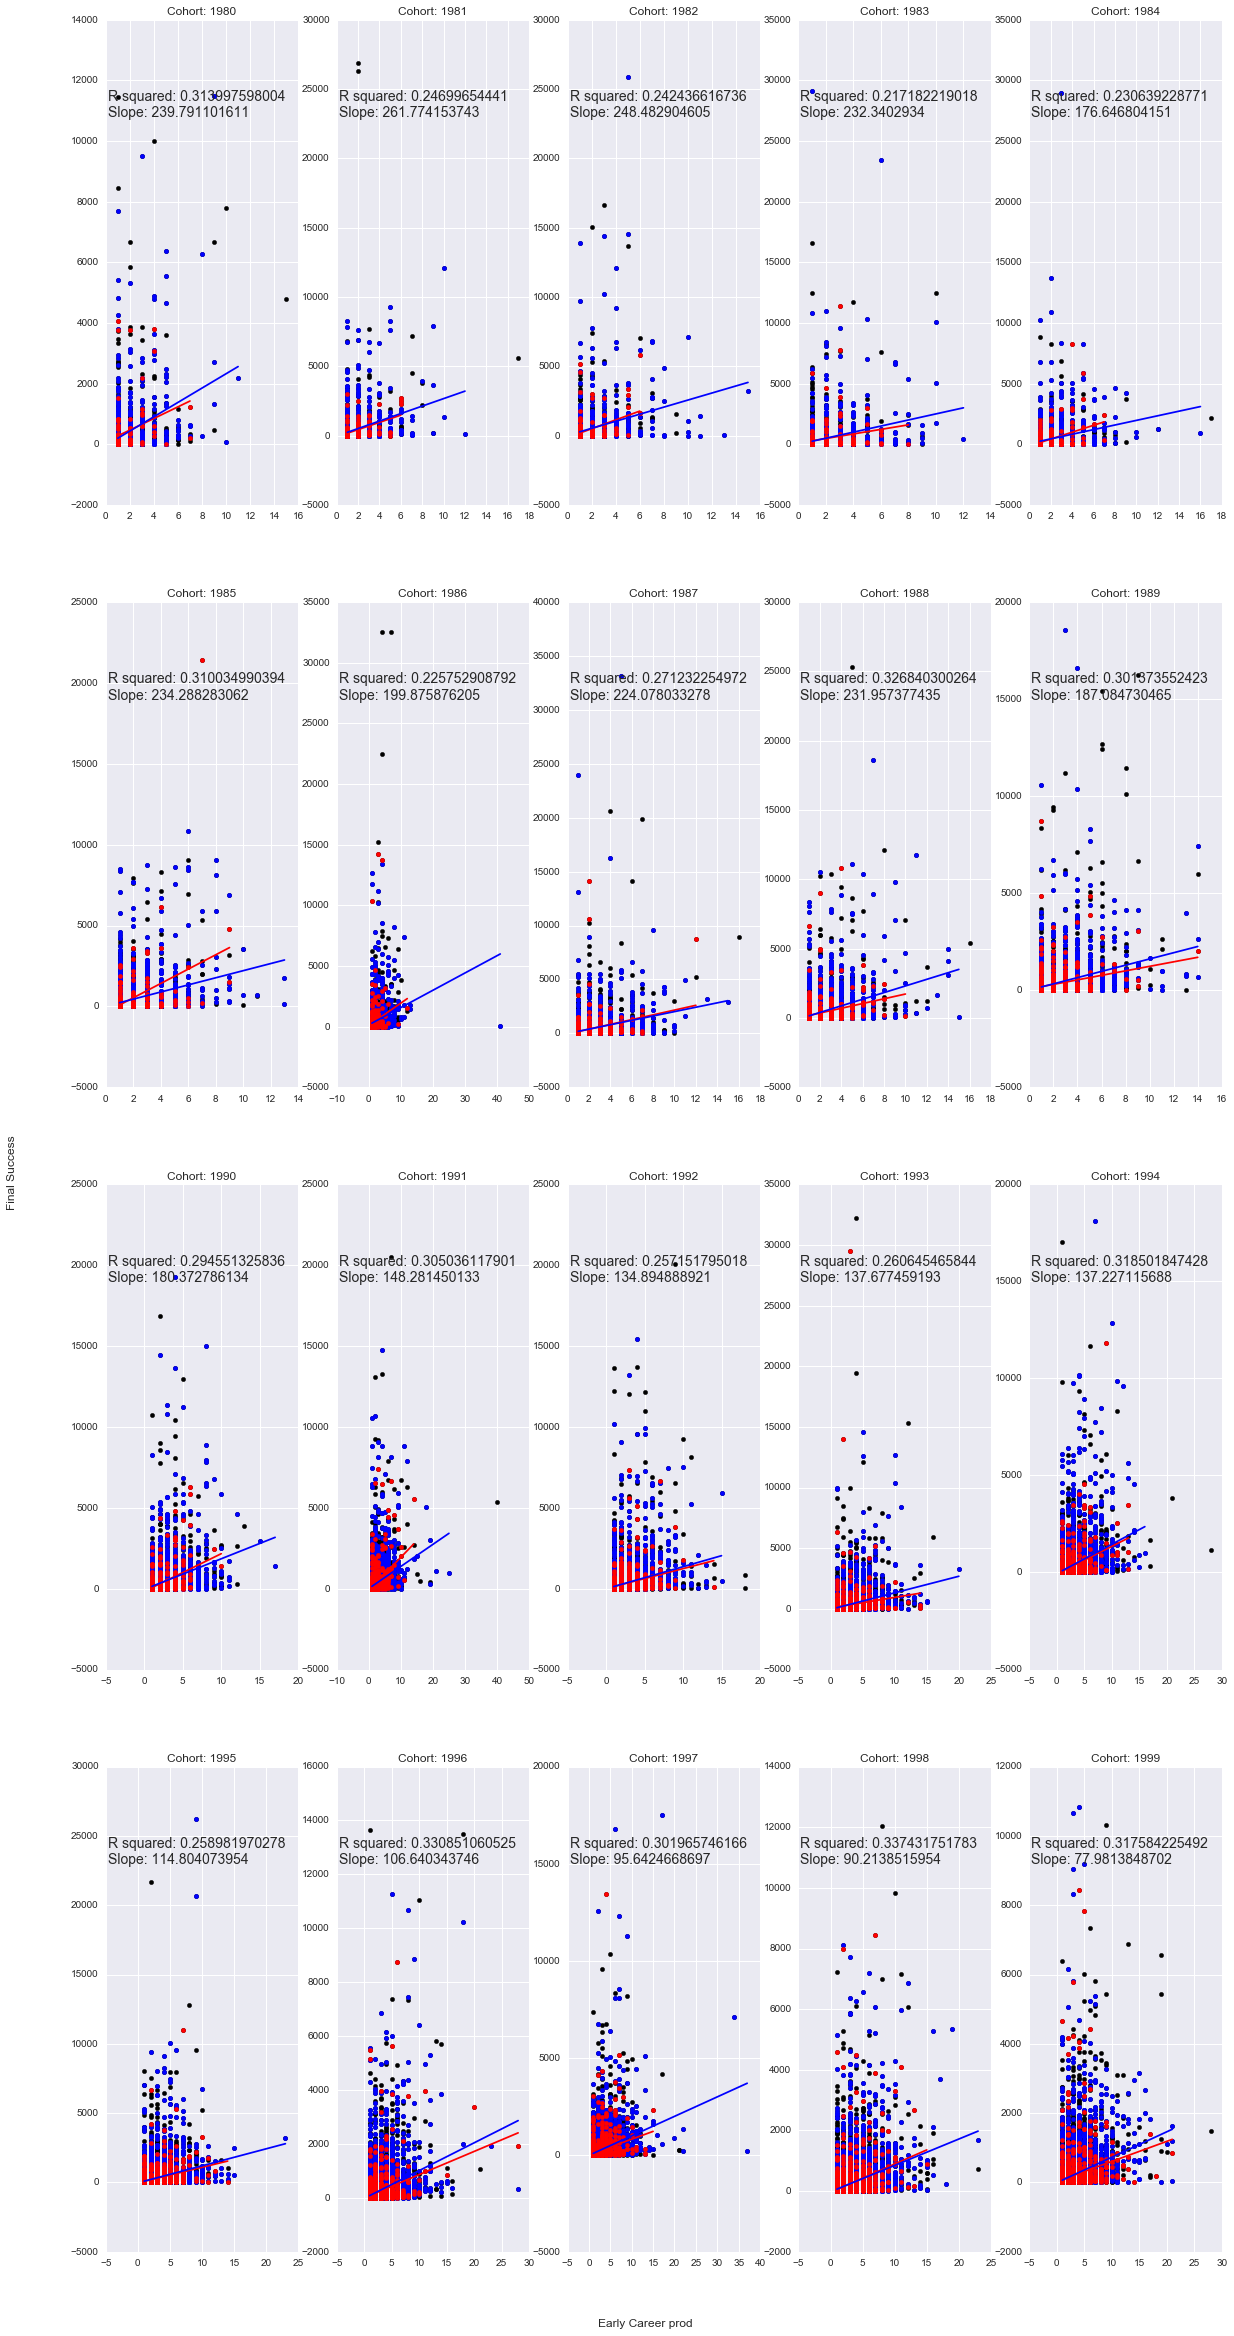

     year  num_obs  group       slope  intercept   r_value       p_value  \
0  1980.0   1361.0    all  239.791102 -19.983805  0.313998  1.598583e-32   
1  1980.0    782.0    men  236.215133 -33.695468  0.325885  8.350330e-21   
2  1980.0    101.0  women  191.463440  88.644970  0.269597  6.403575e-03   
3  1981.0   1536.0    all  261.774154  -8.704776  0.246997  8.789008e-23   
4  1981.0    870.0    men  269.840444 -23.677167  0.311646  4.754907e-21   

     std_err  
0  19.667860  
1  24.536709  
2  68.733328  
3  26.221306  
4  27.925438  


In [7]:
from matplotlib.lines import Line2D

numcols = 5
start_range = 1980
end_range = 2000
cells = end_range - start_range
numrows = int(cells/numcols)

var = "prod" # can also be qual

results = pd.DataFrame(columns=["year", "num_obs", "group", "slope", "intercept", "r_value", "p_value", "std_err"])
fig, ax = plt.subplots(nrows=numrows, ncols=numcols, sharex=False, sharey=False, figsize=(20,40))

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
for year in range(start_range, end_range):
    data = credible_authors.loc[year]
    x = data['early_career_'+var]
    y = data['final_citation_count']
    x_f = data[data.gender == 'f']['early_career_'+str(var)]
    y_f = data[data.gender == 'f']['final_citation_count']
    x_m = data[data.gender == 'm']['early_career_'+str(var)]
    y_m = data[data.gender == 'm']['final_citation_count']
    axes = ax[(year-start_range)//numcols,year%start_range%numcols]
    axes.scatter(x, y, color="black")
    axes.scatter(x_m, y_m, color="blue")
    axes.scatter(x_f, y_f, color="red")
    fit = np.polyfit(x, y, deg=1)
    fit_f = np.polyfit(x_f, y_f, deg=1)
    fit_m = np.polyfit(x_m, y_m, deg=1)
    #axes.plot(x, fit[0] * x + fit[1], color='black')
    axes.plot(x_f, fit_f[0] * x_f + fit_f[1], color='red')
    axes.plot(x_m, fit_m[0] * x_m + fit_m[1], color='blue')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    results = results.append({"year":year, "num_obs":len(x), "group":"all", "slope":slope, "intercept":intercept, 
                              "r_value":r_value, "p_value":p_value, "std_err":std_err}, ignore_index=True)
    
    m_slope, m_intercept, m_r_value, m_p_value, m_std_err = scipy.stats.linregress(x_m, y_m)
    results = results.append({"year":year, "num_obs":len(x_m), "group":"men", "slope":m_slope, "intercept":m_intercept, 
                              "r_value":m_r_value, "p_value":m_p_value, "std_err":m_std_err}, ignore_index=True)
    f_slope, f_intercept, f_r_value, f_p_value, f_std_err = scipy.stats.linregress(x_f, y_f)
    results = results.append({"year":year, "num_obs":len(x_f), "group":"women", "slope":f_slope, "intercept":f_intercept, 
                              "r_value":f_r_value, "p_value":f_p_value, "std_err":f_std_err}, ignore_index=True)
    
    #print(slope, intercept)
    #axes.add_artist(axes.legend("R squared: " + str(r_value), loc=2))
    axes.annotate("R squared: " + str(r_value)+"\nSlope: "+str(slope), xy=(0.01,0.8), xycoords='axes fraction', fontsize=14)
    #axes.legend(custom_lines, ['Female', 'Male', 'All'], loc=1)
fig.text(0.5, 0.1, 'Early Career '+str(var), ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()
fig.savefig("fig/earlycareer_"+str(var)+"_final_success.png", edgecolor='none', bbox_inches='tight')

print(results.head())
results.to_csv("fig/earlycareer_"+str(var)+"_final_success.csv")


In [8]:
credible_authors.reset_index(inplace=True)

In [9]:
#print(credible_authors.head(n=1))
print(credible_authors[credible_authors['author'] == 'donatella sciuto'].head(5))

#print("-----------------------------------------")
#print(authorPublicationData.head(n=1))

print("-----------------------------------------")

print(authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(5))


        start_year            author  end_year  total_num_pub  career_length  \
399779        1987  donatella sciuto      2016            349             30   

        early_career_prod  early_career_prod_1  early_career_prod_2  \
399779                  4                    1                    3   

        early_career_qual  final_citation_count gender  
399779                 14                2376.0      f  
-----------------------------------------
                  author  year                                pub_id
50670   donatella sciuto  2005  9000e8c1-35a6-4a3b-a648-bcb98feac860
57989   donatella sciuto  2005  4836efdb-4645-4846-a0a2-2f7d8ee5e64c
69757   donatella sciuto  2006  6d6e8d1b-e960-44d8-bf00-f60c3426e685
96374   donatella sciuto  2006  2738b6cc-0b81-4029-8e9e-e7d52eb7b735
174652  donatella sciuto  2001  e5f3f1ff-6f56-4633-908b-4de4e353dd8a


In [ ]:
temp = authorPublicationData.groupby(['year','author']).count().reset_index()
temp = temp.rename(columns={'pub_id':'num_pub'}, inplace=False)

#print(temp[temp['author'] == 'donatella sciuto'].head(3))


In [ ]:
authorPublicationData = temp.merge(credible_authors, how="inner", on=["author"])

print(authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(3))

authorPublicationData.shape



In [ ]:
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

#print(np.unique(groupByYearData['gender']))
#authorPublicationData['gender'] = authorPublicationData['gender'].fillna('none')


In [ ]:
years = groupByYearData['year'].unique()
years = sorted(years)
END_YEAR = 2018
CAREER_LENGTH = 5
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

# here is a bug; total_num_pub of this author is 349; num_pub and cum_num_pub should only contain publications in "year"
print(groupByYearData.head(n=1))
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications")  

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications")  